In [29]:
import pandas as pd
from collections import Counter
import collections 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statistics

# Overview of Drug NER Dataset

### Initially loda and prepare data

In [6]:
final_df = pd.read_pickle('intermediate_store/final_df_v1.0.pickle')
final_df.shape

(3507, 8)

In [7]:
final_df.columns

Index(['index', 'dream_id', 'name', 'description', 'lang', 'clean_description',
       'stanza_doc', 'conll'],
      dtype='object')

In [8]:
#Sanity Checks
final_df['dream_id'].duplicated().any()

def get_doc_length(doc):
    length=0
    doc_dict = doc.to_dict()
    for sent in doc_dict:
        length+=len(sent)
    return length
final_df['doc_len'] = final_df.stanza_doc.apply(lambda doc: get_doc_length(doc))
#final_df.doc.apply(lambda doc: get_doc_length(doc)).sort_values(ascending=False).head(20)
final_df['doc_len'].head()

0     18
1    166
2     40
3     60
4     48
Name: doc_len, dtype: int64

In [45]:
# Document length in Tokens according to stanza
print('Sum: ', final_df['doc_len'].sum())
print('Min: ', final_df['doc_len'].min())
print('Max: ', final_df['doc_len'].max())
print('Mean: ', final_df['doc_len'].mean())
print('Median: ', final_df['doc_len'].median())

Sum:  364003
Min:  3
Max:  534
Mean:  103.79327060165383
Median:  61.0


In [47]:
#+ 80% quantile of document length in tokens
final_df['doc_len'].quantile(q=0.8)

176.0

In [83]:
final_df[final_df['doc_len']>500]['clean_description'].iloc[15]

'Exceptionally flavoursome and potent , Blue Haze from Zamnesia Seeds is a hybrid strain of discerning character and sophistication. A choice mix of Blueberry and Haze strains , Blue Haze manages to draw out the very best from both sides. Her shortened flowering time of just 9 weeks leaves other haze strains for dust. ZAMNESIA SEEDS - BLUE HAZE A KNOCKOUT STRAIN WITH FRUITS AND BERRIES GALORE. Blue Haze from Zamnesia. Seeds is a hybrid strain rife with both flavour and flair. This sweet number was the result of mixing Blueberry with Amnesia Haze , culminating in a strain of undeniable power and panache. As soon as you take your first hit of Blue Haze your taste buds are treated to a mouth watering mix of berries , citrus and other various sweet undertones. In terms of the experience , Blue Haze induces an incredibly euphoric and uplifting high - be warned , too much and you ll be swept off into dreamland in a snap. This high potency not only makes Blue Haze appealing to recreational us

In [57]:
pd.set_option('display.max_rows', None)
final_df[['doc_len', 'char_doc_len']].sort_values("doc_len")

,doc_len,char_doc_len
2314,3,30
1801,4,28
2230,4,35
750,4,25
922,4,26
2075,4,32
595,4,29
2041,4,30
895,5,31
1134,5,28


In [64]:
final_df[final_df['doc_len'] == 176]['char_doc_len'].mean()

1006.1111111111111

In [44]:
final_df['char_doc_len'] = final_df.clean_description.apply(lambda descr: len(descr) )
print('Mean: ', final_df['char_doc_len'].mean())
print('Median: ', final_df['char_doc_len'].median())
print('Min: ', final_df['char_doc_len'].min())
print('Max: ', final_df['char_doc_len'].max())
print('Sum: ', final_df['char_doc_len'].sum())


Mean:  572.6019389791845
Median:  334.0
Min:  25
Max:  2930
Sum:  2008115


### Statistics about which drug spans were present

In [14]:
def get_drugspan_counter(row):
    counter = collections.Counter()      
    span_list=[]
    in_span=False
    span=""
    for sentence in row['conll']: #Sentence separation is not strict --> drugs can be spanned over two "sentences"
        for line in sentence:#token has indx 1 and label is in misc in indx 9
            
            label = line[9].split('|')[2].split('=')[1] # line[9] looks like: 'start_char=0|end_char=4|label=O'
            if in_span:
                if label == 'B-Drug':
                    span_list.append(span.lower()) 
                    span = line[1]
                    in_span = True
                elif label == 'I-Drug':
                    span += ' ' + line[1]
                    in_span = True
                elif label == 'O':
                    span_list.append(span.lower()) 
                    span=""
                    in_span=False
                else:
                    print('WTF is this label: ',label)
            else:
                if label == 'B-Drug':
                    span = line[1]
                    in_span=True
                elif label == 'I-Drug':
                    print('Why am I in here: ',label, ' row: ', row.name, ' token: ', line[1], ' tokenid: ', line[0])
                    #do nothing
    if in_span:
        span_list.append(span.lower())
        span=""
        in_span=False
            
    return collections.Counter(span_list)
    #return span_list

final_df['drugspan_counter'] = final_df.apply(lambda row: get_drugspan_counter(row), axis=1)
final_df['drugspan_counter'][184]

Counter({'melanotan': 2,
         '2 ing - ac - nie cyclo asp - his -d - arg - trp - lys benzyl': 1,
         'alcohol': 1})

In [15]:
drugspan_counter = final_df['drugspan_counter'].sum()
drugspan_dict = dict(drugspan_counter)

sorted( ((v,k)for k,v in drugspan_dict.items()), reverse=True)

[(476, 'cocaine'),
 (435, 'thc'),
 (427, 'mdma'),
 (365, 'cannabis'),
 (350, 'indica'),
 (336, 'sativa'),
 (237, 'hash'),
 (215, 'weed'),
 (214, 'lsd'),
 (175, 'hybrid'),
 (154, 'xanax'),
 (151, 'cbd'),
 (150, 'marijuana'),
 (120, 'og kush'),
 (116, 'xtc'),
 (114, 'sour diesel'),
 (104, 'alprazolam'),
 (96, 'oxycodone'),
 (95, 'heroin'),
 (93, 'speed'),
 (93, 'adderall'),
 (91, 'amphetamine'),
 (85, 'steroid'),
 (85, 'coke'),
 (80, 'viagra'),
 (77, 'kush'),
 (75, 'blue dream'),
 (74, 'northern lights'),
 (73, 'white widow'),
 (71, 'meth'),
 (71, 'ketamine'),
 (71, 'haze'),
 (70, 'cialis'),
 (62, 'skunk'),
 (62, 'diazepam'),
 (59, 'dmt'),
 (59, 'amnesia haze'),
 (58, 'fentanyl'),
 (54, 'oxycontin'),
 (54, 'mushrooms'),
 (53, 'steroids'),
 (52, 'shatter'),
 (51, 'crystal meth'),
 (51, 'benzodiazepine'),
 (45, 'opioid'),
 (45, 'gorilla glue'),
 (45, 'girl scout cookies'),
 (44, 'opium'),
 (44, 'modafinil'),
 (43, 'valium'),
 (41, 'tramadol'),
 (41, 'testosterone'),
 (40, 'morphine'),
 (39

In [27]:
drugspan_list = [*drugspan_dict.keys()]
drugspan_list_charlength = [len(span) for span in drugspan_list]

In [35]:
print('Mean: ', statistics.mean(drugspan_list_charlength))
print('Median: ', statistics.median(drugspan_list_charlength))
print('Max: ', max(drugspan_list_charlength))
print('Min: ', min(drugspan_list_charlength))
print('Sum: ', sum(drugspan_list_charlength))

Mean:  12.056102362204724
Median:  10.0
Max:  80
Min:  1
Sum:  36747


In [37]:
drugspan_list_charlength.index(1)

810

In [38]:
drugspan_list[810]

'e'

In [41]:
#AMT words per span
stripped_spans = [span.strip() for span in drugspan_list]
amt_words = [span.count(" ")+1 for span in stripped_spans]
print('Mean: ', statistics.mean(amt_words))
print('Median: ', statistics.median(amt_words))
print('Max: ', max(amt_words))
print('Min: ', min(amt_words))
print('Sum: ', sum(amt_words))

Mean:  1.8828740157480315
Median:  2.0
Max:  20
Min:  1
Sum:  5739


In [ ]:
#AMT words per span
stripped_spans = [span.strip() for span in drugspan_list]
amt_words = [span.count(" ")+1 for span in stripped_spans]
print('Mean: ', statistics.mean(amt_words))
print('Median: ', statistics.median(amt_words))
print('Max: ', max(amt_words))
print('Min: ', min(amt_words))
print('Sum: ', sum(amt_words))

In [87]:
#Checkout what rare spans are
listOfRareSpans = {(key, value)  for (key, value) in drugspan_dict.items() if value  < 20}
listOfRareSpans

{('clomid clomiphene', 1),
 ('mdp2p', 1),
 ('criminal', 2),
 ('stoned', 1),
 ('comid', 1),
 ('lemon kush', 10),
 ('norco', 7),
 ('freezelands145', 1),
 ('vs', 1),
 ('nd - 10', 1),
 ('anadrol oxymethalone', 1),
 ('lucy', 2),
 ('green bali kratom', 1),
 ('rug burn og', 3),
 ('chemdog og type 60', 1),
 ('rope', 3),
 ('nlx northern light weed', 1),
 ('critical hog', 1),
 ('white on white', 3),
 ('east coast sour d flowering', 1),
 ('hazey train', 1),
 ('lucky 13', 1),
 ('viagra soft', 1),
 ('human chorionic gonadotropin', 5),
 ('acrylfentantyl', 2),
 ('ketamine isomer s', 6),
 ('19 - nor - 9,11 - testosterone 17 - enanthate', 1),
 ('methylcybin', 1),
 ('morphine hydrochloride', 1),
 ('nyc sour diesel', 3),
 ('n - acetyl - p - aminophenol', 1),
 ('cannabinoid', 10),
 ('diamorphin 45', 1),
 ('iktorivil', 1),
 ('sour tangie terps', 1),
 ('oxycodonhydrochlorid lannacher', 1),
 ('ketarol', 1),
 ('tren - e', 2),
 ('girlscout cookies', 1),
 ('canabinol cbn', 1),
 ('sticks and stones og', 1),
 ('x

# General Statistics

In [8]:
train, test = train_test_split(final_df, test_size=0.2, random_state=42)
train, dev = train_test_split(train, test_size=0.2, random_state=42)
print('Train: %d lines, dev: %d lines, test: %d lines'%(len(train), len(dev), len(test)))

print('Overall %d drug spans are included!'%(sum(drugspan_dict.values())))



Train: 2244 lines, dev: 561 lines, test: 702 lines
Overall 14934 drug spans are included!


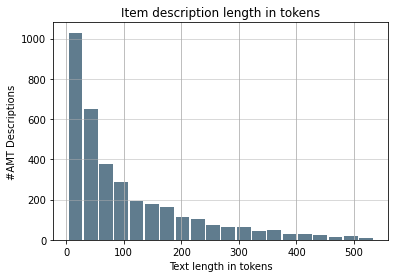

In [66]:
final_df.doc_len.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Item description length in tokens')
plt.xlabel('Text length in tokens')
plt.ylabel('#AMT Descriptions')
plt.grid(axis='y', alpha=0.6)

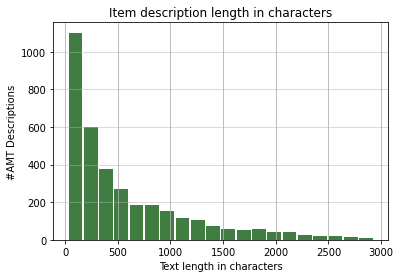

In [67]:
final_df.char_doc_len.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#3F7D40')
plt.title('Item description length in characters')
plt.xlabel('Text length in characters')
plt.ylabel('#AMT Descriptions')
plt.grid(axis='y', alpha=0.6)

# Visualize Drug Span Occurences

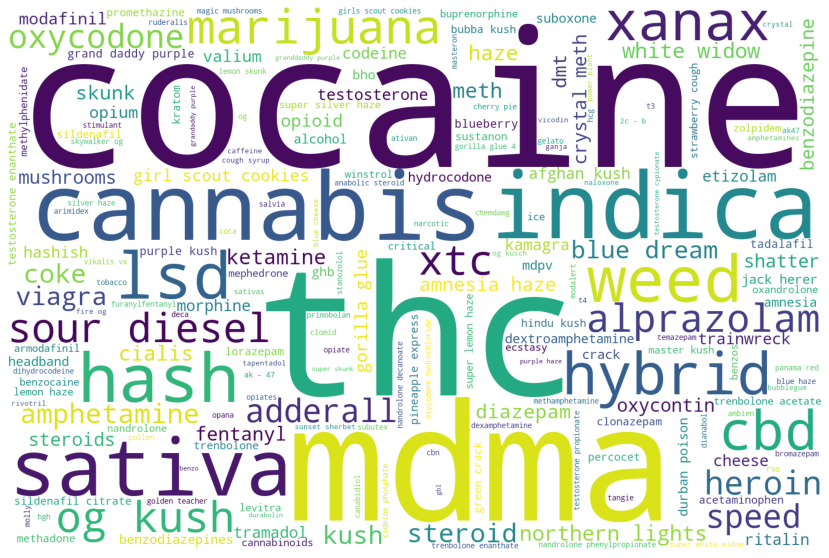

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                      width=1500,
                      height=1000
                      ).generate_from_frequencies(drugspan_dict)
# use .generate(space_separated_string) - to generate cloud from text

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [11]:
#TODO 
#Which tags are only present in test/dev but not in train?? 

In [12]:
test_data = np.array(list(drugspan_dict.values()))
print('there are %d unique drug spans/texts'%(len(test_data)))

there are 3048 unique drug spans/texts


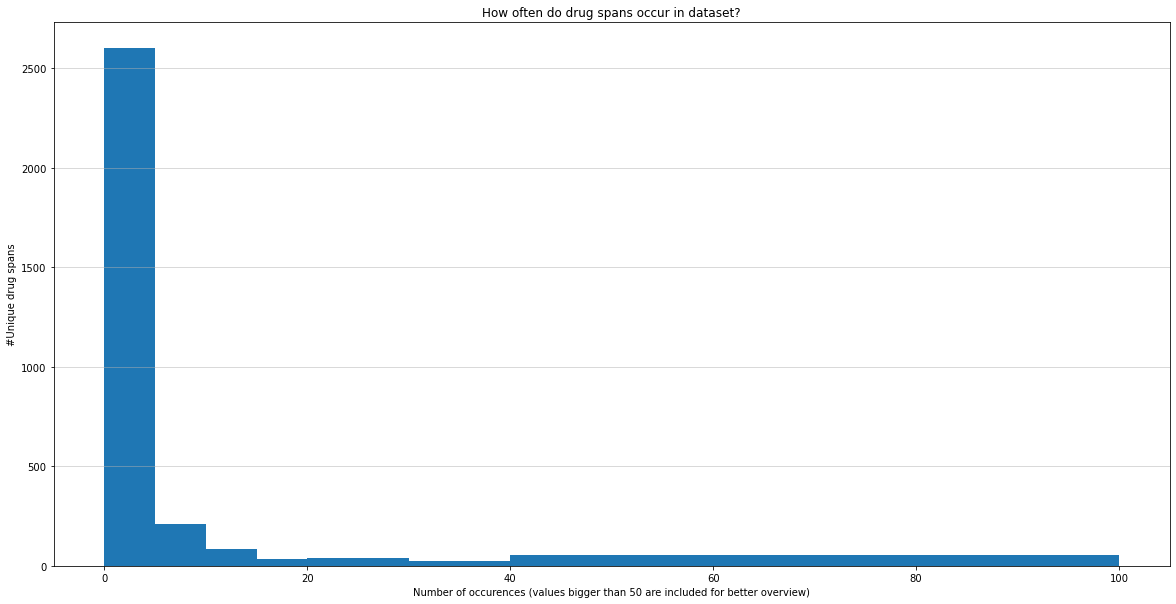

In [13]:
bins = [0, 5, 10, 15, 20, 30, 40, 100]
plt.figure(figsize=(20, 10))
plt.hist(np.clip(test_data, bins[0], bins[-1]), bins=bins)
plt.title('How often do drug spans occur in dataset?')
plt.xlabel('Number of occurences (values bigger than 50 are included for better overview)')
plt.ylabel('#Unique drug spans')
plt.grid(axis='y', alpha=0.6)


In [14]:
#create pie chart to visualize how many "rare items" are included.

In [17]:
pie_labels = ["Spans occuring 1 time", "Spans occuring 2-5 times", "Spans occuring 6-10 times", "Spans occuring 11-20 times",
              "Spans occuring 21-50 times", "Spans occuring 51-100 times", "Spans occuring 101+ times"]
length_cats=[0, 0, 0, 0, 0, 0, 0]
amt_of_spans = sum(drugspan_dict.values())

for k,v in drugspan_dict.items():
    if v == 1:
        length_cats[0] = length_cats[0] + v
    elif v >= 2 and v <= 5:
        length_cats[1] = length_cats[1] + v
    elif v >= 5 and v <= 10:
        length_cats[2] = length_cats[2] + v
    elif v >= 11 and v <= 20:
        length_cats[3] = length_cats[3] + v
    elif v >= 21 and v <= 50:
        length_cats[4] = length_cats[4] + v
    elif v >= 51 and v <= 100:
        length_cats[5] = length_cats[5] + v
    elif v > 101:
        length_cats[6] = length_cats[6] + v
        
relative_length_cats = [el/amt_of_spans for el in length_cats ]
relative_length_cats

[0.12146779161644569,
 0.16238114369894202,
 0.0800187491629838,
 0.09267443417704567,
 0.13807419311637872,
 0.12823088254988615,
 0.27715280567831796]

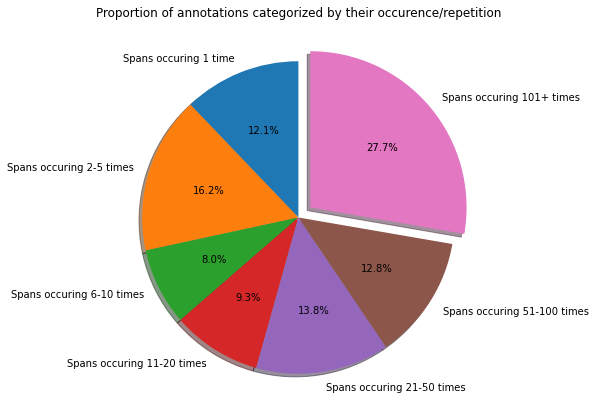

In [21]:
explode = (0, 0, 0, 0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.figure(figsize=(7, 10))
#fig1, ax1 = plt.subplots()
plt.pie(relative_length_cats, explode=explode, 
        labels=pie_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.title('Of %d total annotations, how often did they occur in the dataset?'%amt_of_spans)
plt.title('Proportion of annotations categorized by their occurence/repetition')
#plt.xlabel('Proportion of annotations by their occurences')
plt.show()